# 2025 Time Series Forecasting using Kalman Filter For MacOS

Backgound on the Kalman Filter:
https://en.wikipedia.org/wiki/Kalman_filter 

Python Library Used: 
https://unit8co.github.io/darts/

In [1]:
import glob
import json
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import os
from darts import TimeSeries # type: ignore
from darts.models import KalmanForecaster # type: ignore
import os
from datetime import datetime, timedelta
import requests # type: ignore
from tqdm import tqdm # type: ignore

In [2]:
# Define the URL and file paths
url = 'https://nvd.handsonhacking.org/nvd.jsonl'
nvd_folder = './Data'
nvd_file_path = os.path.join(nvd_folder, 'nvd.jsonl')

# Create the NVD folder if it doesn't exist
os.makedirs(nvd_folder, exist_ok=True)

# Check if the file exists and is less than 24 hours old
if os.path.exists(nvd_file_path):
    file_mod_time = datetime.fromtimestamp(os.path.getmtime(nvd_file_path))
    if datetime.now() - file_mod_time < timedelta(hours=24):
        print(f"File is less than 24 hours old. Skipping download: {nvd_file_path}")
    else:
        # File is older than 24 hours, delete it and download a new copy
        os.remove(nvd_file_path)
        print("File is older than 24 hours. Downloading a new copy...")
else:
    print("File does not exist. Downloading a new copy...")

# Download the file if it doesn't exist or was deleted
if not os.path.exists(nvd_file_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(nvd_file_path, 'wb') as file:
        for data in response.iter_content(block_size):
            tqdm_bar.update(len(data))
            file.write(data)
    tqdm_bar.close()
    if total_size != 0 and tqdm_bar.n != total_size:
        print('ERROR: Something went wrong')
    else:
        print(f'Downloaded {nvd_file_path}')

File is less than 24 hours old. Skipping download: ./Data/nvd.jsonl


In [3]:
row_accumulator = []

for filename in glob.glob('Data/nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            if 'configurations' in entry['cve']:
                for config in entry['cve']['configurations']:
                    for node in config['nodes']:
                        if 'cpeMatch' in node:
                            for cpe in node['cpeMatch']:
                                if cpe['vulnerable']:
                                    cve = entry['cve']['id']
                                    # Use .get() to safely access 'cvssMetricV31'
                                    cvss_score = (
                                        entry['cve']['metrics']
                                        .get('cvssMetricV31', [{}])[0]
                                        .get('cvssData', {})
                                        .get('baseScore', 'Unknown')
                                    )
                                    published_date = entry['cve'].get('published', 'Missing_Data')
                                    cpe_string = cpe['criteria']
                                    end = cpe.get('versionEndExcluding', 'None')
                                    end2 = cpe.get('versionEndIncluding', 'None')
                                    start = cpe.get('versionStartExcluding', 'None')
                                    start2 = cpe.get('versionStartIncluding', 'None')

                                    new_row = {
                                        'CVE': cve,
                                        'CVSS Score': cvss_score,
                                        'Published': published_date,
                                        'CPE': cpe_string,
                                        'StartI': start if start != 'None' else None,
                                        'StartE': start2 if start2 != 'None' else None,
                                        'EndI': end if end != 'None' else None,
                                        'EndE': end2 if end2 != 'None' else None
                                    }
                                    row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd['Published'] = pd.to_datetime(nvd['Published'], errors='coerce')
thisyear = (nvd['Published'] > '2000-01-01') & (nvd['Published'] < '2026-01-01')
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])



In [4]:
nvd['CVSS Score'].value_counts()

CVSS Score
Unknown    1209617
7.5         128138
7.8         119936
9.8          79751
5.5          65935
            ...   
1.8             46
1.6             21
0.0             19
1.7              7
9.2              6
Name: count, Length: 85, dtype: int64

In [5]:
# Function to split the CPE field into its components
def deconstruct_cpe(cpe_string):
    # Split the CPE string into parts
    cpe_parts = cpe_string.split(':')
    
    # Ensure the CPE string has the correct number of parts (13 including "cpe")
    while len(cpe_parts) < 13:
        cpe_parts.append('')  # Fill missing parts with empty strings
    
    # Return the parts as a dictionary
    return {
        'cpe_version': cpe_parts[1],
        'part': cpe_parts[2],
        'vendor': cpe_parts[3],
        'product': cpe_parts[4],
        'version': cpe_parts[5],
        'update': cpe_parts[6],
        'edition': cpe_parts[7],
        'language': cpe_parts[8],
        'sw_edition': cpe_parts[9],
        'target_sw': cpe_parts[10],
        'target_hw': cpe_parts[11],
        'other': cpe_parts[12]
    }

# Apply the function to the 'CPE' column and expand the result into separate columns
cpe_columns = nvd['CPE'].apply(deconstruct_cpe).apply(pd.Series)

# Merge the new columns into the original DataFrame
nvd = pd.concat([nvd, cpe_columns], axis=1)

# Display the updated DataFrame with the deconstructed CPE fields
nvd[['CVE', 'CVSS Score', 'CPE', 'cpe_version', 'part', 'vendor', 'product', 'version', 'update', 'edition', 'language', 'sw_edition', 'target_sw', 'target_hw', 'other']]

,CVE,CVSS Score,CPE,cpe_version,part,vendor,product,version,update,edition,language,sw_edition,target_sw,target_hw,other
4931,CVE-1999-0964,Unknown,cpe:2.3:o:freebsd:freebsd:2.1.6:*:*:*:*:*:*:*,2.3,o,freebsd,freebsd,2.1.6,*,*,*,*,*,*,*
4932,CVE-2000-0069,Unknown,cpe:2.3:a:sun:solstice_backup:5.1:*:*:*:*:*:*:*,2.3,a,sun,solstice_backup,5.1,*,*,*,*,*,*,*
4933,CVE-2000-0120,Unknown,cpe:2.3:a:allaire:spectra:1.0:*:*:*:*:*:*:*,2.3,a,allaire,spectra,1.0,*,*,*,*,*,*,*
4934,CVE-2000-0077,Unknown,cpe:2.3:o:hp:hp-ux:10:*:*:*:*:*:*:*,2.3,o,hp,hp-ux,10,*,*,*,*,*,*,*
4935,CVE-2000-0077,Unknown,cpe:2.3:o:hp:hp-ux:11:*:*:*:*:*:*:*,2.3,o,hp,hp-ux,11,*,*,*,*,*,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210945,CVE-2025-3384,7.3,cpe:2.3:a:1000projects:human_resource_manageme...,2.3,a,1000projects,human_resource_management_system,1.0,*,*,*,*,*,*,*
2210946,CVE-2025-3397,4.3,cpe:2.3:a:yzmcms:yzmcms:7.1:*:*:*:*:*:*:*,2.3,a,yzmcms,yzmcms,7.1,*,*,*,*,*,*,*
2210947,CVE-2025-3399,7.3,cpe:2.3:a:esafenet:cdg:5.6.3.154.205_20250114:...,2.3,a,esafenet,cdg,5.6.3.154.205_20250114,*,*,*,*,*,*,*
2210948,CVE-2025-3400,7.3,cpe:2.3:a:esafenet:cdg:5.6.3.154.205_20250114:...,2.3,a,esafenet,cdg,5.6.3.154.205_20250114,*,*,*,*,*,*,*


In [10]:
# Filter the DataFrame to keep only rows where vendor is "microsoft" and product is "windows_server"
nvd_filtered = nvd[(nvd['vendor'].str.lower() == 'apple') & (nvd['product'].str.contains('macos', case=False, na=False))]

# Display the filtered DataFrame
nvd_filtered = nvd_filtered[['CVE', 'CVSS Score', 'Published', 'vendor', 'product']]
nvd_filtered = nvd_filtered.sort_values(by=['Published'])
nvd_filtered = nvd_filtered.reset_index(drop=True)
nvd_filtered['Published'] = pd.to_datetime(nvd_filtered['Published'], errors='coerce')
nvd_filtered['Published'] = nvd_filtered['Published'].dt.date

nvd_filtered = nvd_filtered.drop_duplicates(subset='CVE')

# Convert CVSS Score to numeric, coercing errors to NaN
nvd_filtered['CVSS Score'] = pd.to_numeric(nvd_filtered['CVSS Score'], errors='coerce')

# Filter rows where CVSS Score is greater than 7.0
nvd_filtered = nvd_filtered[nvd_filtered['CVSS Score'] > 7.0]

# Display the filtered DataFrame
nvd_filtered


,CVE,CVSS Score,Published,vendor,product
4,CVE-2019-14899,7.4,2019-12-11,apple,macos
5,CVE-2020-10663,7.5,2020-04-28,apple,macos
9,CVE-2019-20838,7.5,2020-06-15,apple,macos
12,CVE-2020-9876,7.8,2020-10-22,apple,macos
13,CVE-2020-9883,7.8,2020-10-22,apple,macos
...,...,...,...,...,...
3303,CVE-2025-30465,9.8,2025-03-31,apple,macos
3310,CVE-2025-30471,7.5,2025-03-31,apple,macos
3313,CVE-2025-31182,9.8,2025-03-31,apple,macos
3315,CVE-2025-31183,9.8,2025-03-31,apple,macos


In [11]:
from datetime import date

pastdata = ((nvd_filtered['Published'] > date(2017, 1, 1)) & (nvd_filtered['Published'] < date(2025, 1, 1)))
thisyear = ((nvd_filtered['Published'] > date(2025, 1, 1)) & (nvd_filtered['Published'] < date(2026, 1, 1)))
nvd_filtered_2025 = nvd_filtered.loc[thisyear]
nvd_filtered = nvd_filtered.loc[pastdata]

In [12]:
nvd_filtered

,CVE,CVSS Score,Published,vendor,product
4,CVE-2019-14899,7.4,2019-12-11,apple,macos
5,CVE-2020-10663,7.5,2020-04-28,apple,macos
9,CVE-2019-20838,7.5,2020-06-15,apple,macos
12,CVE-2020-9876,7.8,2020-10-22,apple,macos
13,CVE-2020-9883,7.8,2020-10-22,apple,macos
...,...,...,...,...,...
2813,CVE-2024-54528,7.1,2024-12-12,apple,macos
2816,CVE-2024-54529,7.8,2024-12-12,apple,macos
2820,CVE-2024-54534,9.8,2024-12-12,apple,macos
2821,CVE-2024-54538,7.5,2024-12-20,apple,macos


In [15]:
# Ensure the Published column is in datetime format
nvd_filtered['Published'] = pd.to_datetime(nvd_filtered['Published'], errors='coerce')

# Drop rows with invalid datetime values in the Published column
nvd_filtered = nvd_filtered.dropna(subset=['Published'])

# Normalize the Published column to the start of the month
nvd_filtered['Published'] = nvd_filtered['Published'].dt.to_period('M').dt.to_timestamp()

# Group by the Published column and count occurrences
monthly = nvd_filtered['Published'].groupby(nvd_filtered.Published).agg('count')

# Create a DataFrame from the grouped data
monthly_cves = pd.DataFrame(monthly)
monthly_cves.columns = ['Count']
monthly_cves = monthly_cves.reset_index()

# Rename columns for clarity
monthly_cves = monthly_cves.rename(columns={"Published": "Month", "Count": "CVEs"})

# Ensure the Month column is in datetime format
monthly_cves['Month'] = pd.to_datetime(monthly_cves['Month'])

/opt/homebrew/lib/python3.13/site-packages/nfoursid/nfoursid.py:178: RuntimeWarning: divide by zero encountered in matmul
  observability = self.R32 @ np.linalg.pinv(self.R22) @ u_and_y
/opt/homebrew/lib/python3.13/site-packages/nfoursid/nfoursid.py:178: RuntimeWarning: overflow encountered in matmul
  observability = self.R32 @ np.linalg.pinv(self.R22) @ u_and_y
/opt/homebrew/lib/python3.13/site-packages/nfoursid/nfoursid.py:178: RuntimeWarning: invalid value encountered in matmul
  observability = self.R32 @ np.linalg.pinv(self.R22) @ u_and_y


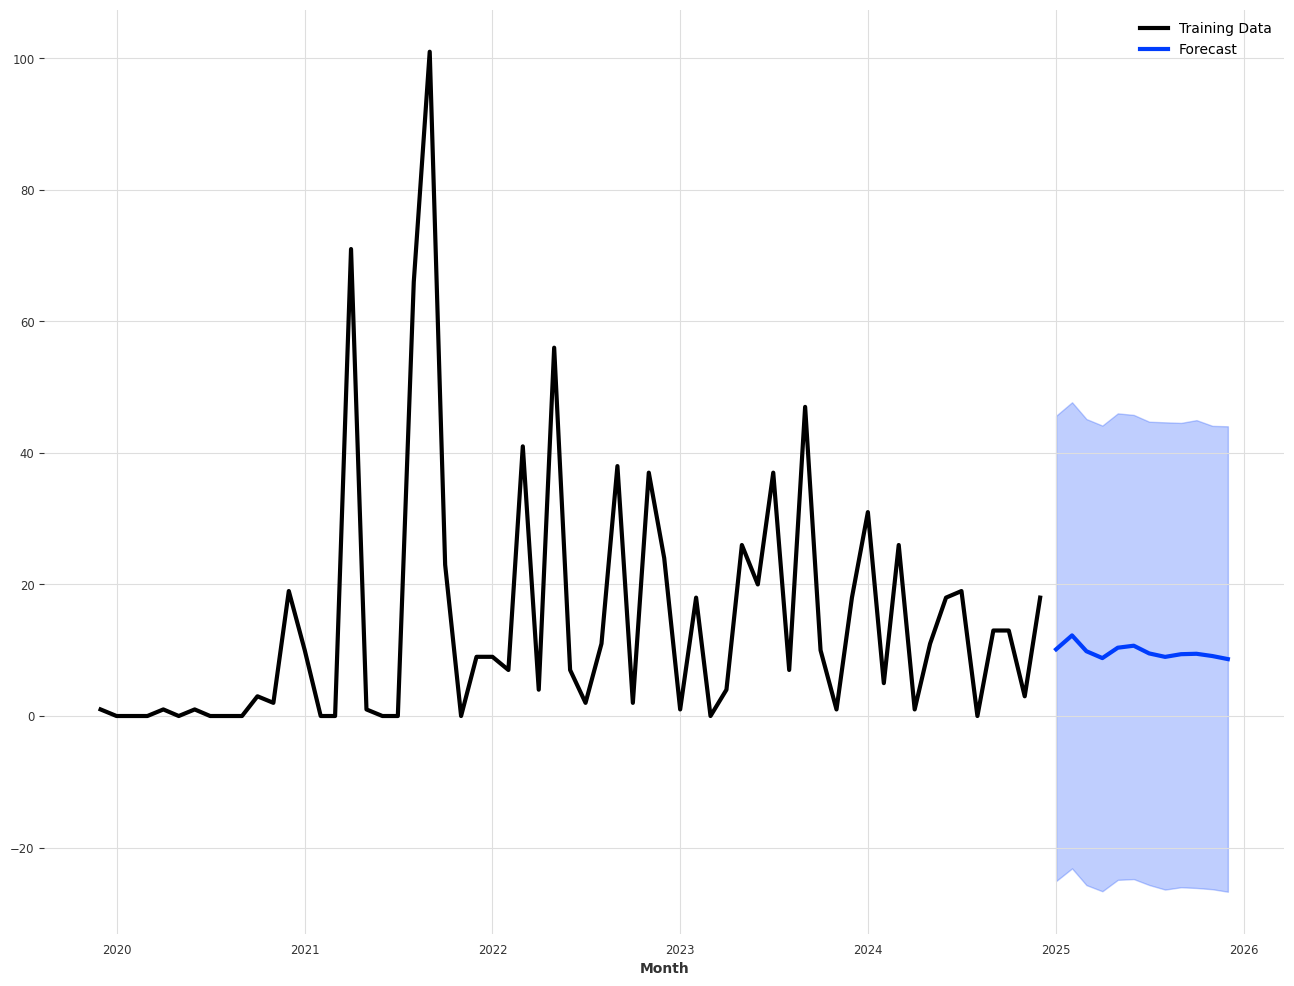

In [16]:
# Ensure the time index has a consistent frequency
if not monthly_cves.empty:
	monthly_cves = monthly_cves.set_index("Month").asfreq("MS").reset_index()

	# Check if there are at least 3 entries in the DataFrame
	if len(monthly_cves) >= 3:
		# Fill missing values in the CVEs column with 0
		monthly_cves['CVEs'] = monthly_cves['CVEs'].fillna(0)

		# Create the TimeSeries object with missing dates filled
		train = TimeSeries.from_dataframe(monthly_cves, "Month", "CVEs", fill_missing_dates=True, freq="MS")

		# Initialize and fit the KalmanForecaster model
		model = KalmanForecaster(dim_x=4)
		model.fit(train)

		# Predict the next 12 months
		pred = model.predict(n=12, num_samples=100000)

		# Plot the results
		plt.figure(figsize=(16, 12))
		train.plot(lw=3, label="Training Data")
		pred.plot(lw=3, label="Forecast")
		plt.legend()
	else:
		print("Not enough data to train the KalmanForecaster. At least 3 entries are required.")
else:
	print("The monthly_cves DataFrame is empty. Cannot proceed with training.")

In [18]:
# Use quantile_df() to handle stochastic TimeSeries if you want a specific quantile
darts_df = pred.quantile_df(quantile=0.5)  # Example: Use the median (50th percentile)

# Process the DataFrame as before
darts_monthly = darts_df.mean(axis=1).round(0)
darts_monthly = darts_monthly.to_frame()
darts_monthly = darts_monthly.reset_index()
darts_monthly = darts_monthly.rename(columns={0: "CVEs Predicted"})
darts_monthly['Month'] = darts_monthly['Month'].dt.month_name()
darts_monthly

,Month,CVEs Predicted
0,January,10.0
1,February,12.0
2,March,10.0
3,April,9.0
4,May,10.0
5,June,11.0
6,July,10.0
7,August,9.0
8,September,9.0
9,October,9.0


In [20]:
darts_monthly['CVEs Predicted'].sum()

117.0

In [22]:
# Ensure the Published column is in datetime format
nvd_filtered_2025['Published'] = pd.to_datetime(nvd_filtered_2025['Published'], errors='coerce')

# Drop rows with invalid datetime values in the Published column
nvd_filtered_2025 = nvd_filtered_2025.dropna(subset=['Published'])

# Group by month and count the occurrences
monthly_2025 = nvd_filtered_2025['Published'].groupby(nvd_filtered_2025['Published'].dt.to_period("M")).agg('count')
monthly_cves_2025 = pd.DataFrame(monthly_2025)
monthly_cves_2025.columns = ['Count']
monthly_cves_2025 = monthly_cves_2025.reset_index()
monthly_cves_2025 = monthly_cves_2025.rename(columns={"Published": "Month", "Count": "CVEs Actual"})
monthly_cves_2025['Month'] = monthly_cves_2025['Month'].astype(str)
monthly_cves_2025['Month'] = pd.to_datetime(monthly_cves_2025['Month'])
monthly_cves_2025['Month'] = monthly_cves_2025['Month'].dt.month_name()
monthly_cves_2025

/var/folders/gw/2xvxmj6d6qn7h4x_jvkps1w00000gn/T/ipykernel_48062/1726100540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvd_filtered_2025['Published'] = pd.to_datetime(nvd_filtered_2025['Published'], errors='coerce')


,Month,CVEs Actual
0,January,31
1,February,1
2,March,73


In [23]:
validation_df = pd.merge(
    monthly_cves_2025,
    darts_monthly,
    how="outer",
    on='Month',
)

month_categories = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December', 'Total']

validation_df['Month'] = pd.Categorical(validation_df['Month'], categories = month_categories, ordered = True)
validation_df = validation_df.sort_values(by='Month')


validation_df

,Month,CVEs Actual,CVEs Predicted
4,January,31.0,10.0
3,February,1.0,12.0
7,March,73.0,10.0
0,April,NaN,9.0
8,May,NaN,10.0
6,June,NaN,11.0
5,July,NaN,10.0
1,August,NaN,9.0
11,September,NaN,9.0
10,October,NaN,9.0


In [24]:
# Fix SettingWithCopyWarning by using .loc
validation_df['Difference'] = validation_df['CVEs Actual'] - validation_df['CVEs Predicted']

# Replace inplace=True with assignment to avoid FutureWarning
validation_df['CVEs Actual'] = validation_df['CVEs Actual'].fillna(0)
validation_df['Difference'] = validation_df['Difference'].fillna(0)

validation_df['Difference'] = validation_df['CVEs Actual'] - validation_df['CVEs Predicted']

numeric_df = validation_df.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)

validation_df = pd.concat([validation_df, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)

# Rename the blank cell in the 'Month' column to 'Total'
validation_df.loc[validation_df.index[-1], 'Month'] = 'Total'

validation_df['CVEs Actual'] = validation_df['CVEs Actual'].fillna(0)
validation_df['Difference'] = validation_df['Difference'].fillna(0)

In [26]:

def percentage_change(col1,col2):
    return ((col2 / col1) * 100).round(0)

validation_df['Precentage'] = percentage_change(validation_df['CVEs Predicted'],validation_df['CVEs Actual'])   

validation_df['Precentage'] = validation_df['Precentage'].fillna(0)
validation_df




,Month,CVEs Actual,CVEs Predicted,Difference,Precentage
0,January,31.0,10.0,21.0,310.0
1,February,1.0,12.0,-11.0,8.0
2,March,73.0,10.0,63.0,730.0
3,April,0.0,9.0,-9.0,0.0
4,May,0.0,10.0,-10.0,0.0
5,June,0.0,11.0,-11.0,0.0
6,July,0.0,10.0,-10.0,0.0
7,August,0.0,9.0,-9.0,0.0
8,September,0.0,9.0,-9.0,0.0
9,October,0.0,9.0,-9.0,0.0
